# Healthy Pandas Code 

<b>Afnan Khan (ak4854)    |   Laurel Hickey (lh3161) |    Shruti Agarwal (sa4136)  |    Yanyi Wang (yw3949) |  Devangi Gaikwad (dsg2160)</b>



   
Red wine has been part of social, religious, and cultural events for centuries. In the past, people have theorized that red wine benefits health, particularly alongside a balanced diet.[1] A 2018 study notes that drinking red wine in moderation has positive links to cardiovascular disease, atherosclerosis, hypertension, certain types of cancer, and type 2 diabetes.[2] These links to health were the primary motivation in looking at wine as initially the goal of this project was to look at something that could affect health, though the data set chosen has all types of wine not just red wine and ultimately, the quality of wine has not been linked to more health benefits.  However, the goal of this analysis is to gain a better understanding of the quality score of wine and to produce a method that will better predict the quality of a bottle of wine based on a review description, price, and geographic information.  In gaining this understanding, it will be easier to identify wines with higher quality.
In this data analysis, the quality of wine is explored using machine learning and text-mining techniques.  The dataset used during this analysis is a dataset from Kaggle.  The data set contains text descriptions of each different wine that are from different individuals on Twitter.  Later in this analysis, text mining including Vader sentiment analysis and topic analysis are done to get a better understanding of the dataset as a whole.  


## Notebook Setup & Imports

In [128]:
#Basic imports
import pandas as pd
import numpy as np
#NLP 
import nltk
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')
#Confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score
#Plot 
import folium
import seaborn as sns
from scipy import stats
import json
#LDA
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict

from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import re
from PIL import Image
from IPython.display import Image as im

from nltk.draw.dispersion import dispersion_plot
import warnings 
warnings.filterwarnings("ignore")

In [129]:
#!pip install gensim==3.6.0
#! conda list| findstr gensim
#!pip install wordcloud
#!pip install pyLDAvis

Load  wine review data 

In [130]:
dataset = 'winemag-data-130k-v2.csv'

In [131]:
df = pd.read_csv(dataset, index_col = 'Unnamed: 0')

# Data Cleaning


Dropping unecessary columns and cleaning duplicated and null data

In [132]:
df = df.dropna(subset=["country", "description", "points", "price", "province", "variety"]).reset_index().drop("index", axis=1)
df = df.drop_duplicates("description")
df["country"] = np.where(df["country"] == "US", "United States of America", df["country"])
df = df.drop(columns = ['designation','region_1','region_2','taster_name','taster_twitter_handle','title','winery'])
df

,country,description,points,price,province,variety
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling
3,United States of America,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot
...,...,...,...,...,...,...
120910,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Riesling
120911,United States of America,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Pinot Noir
120912,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Gewürztraminer
120913,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Pinot Gris


# Exploratory Data Analysis 

<AxesSubplot:xlabel='points'>

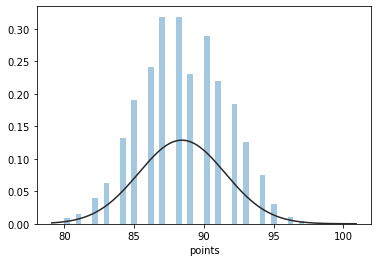

In [133]:
sns.distplot(df['points'], kde=False, fit=stats.norm)

<AxesSubplot:ylabel='Frequency'>

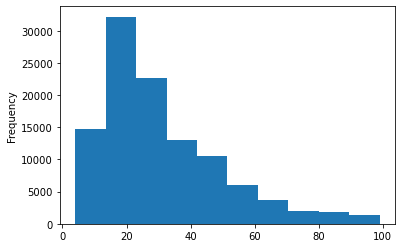

In [134]:
df[df['price'] < 100]['price'].plot.hist()

<AxesSubplot:xlabel='price', ylabel='points'>

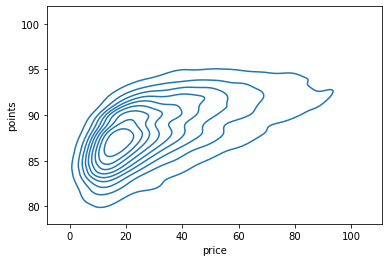

In [135]:
sns.kdeplot(data=df[df['price'] < 100].loc[:, ['price', 'points']].sample(10000), x='price', y='points')

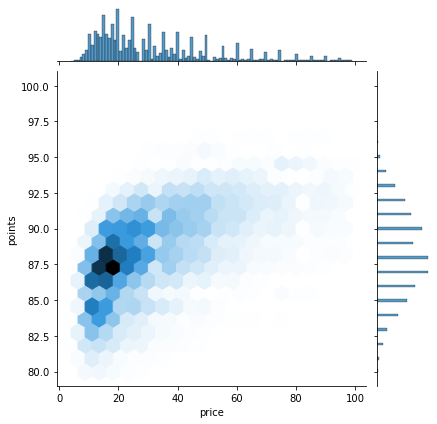

In [136]:
sns.jointplot(x='price', y='points', data=df[df['price'] < 100], kind='hex', gridsize=20)

<AxesSubplot:xlabel='variety', ylabel='points'>

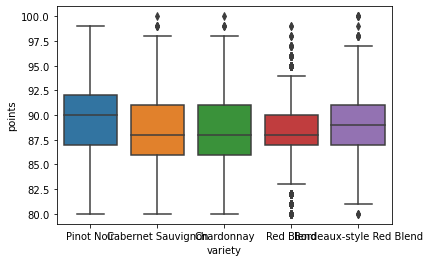

In [137]:
df_top_5 = df[df["variety"].isin(df["variety"].value_counts().head(5).index)]
sns.boxplot(data=df_top_5, x="variety", y="points")

<AxesSubplot:xlabel='points'>

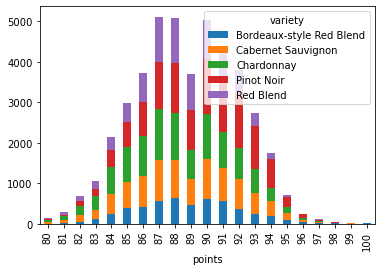

In [138]:
df_top_5[["points", "variety"]].value_counts().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='points', ylabel='description_length'>

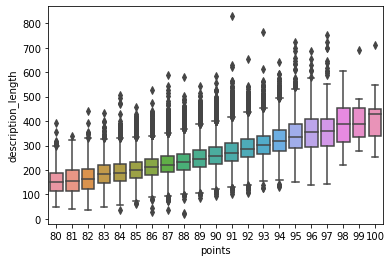

In [139]:
df["description_length"] = df["description"].apply(len)
sns.boxplot(data=df, x="points", y="description_length")


In [140]:

# JSON cleaning
with open("countries.json") as f:
    raw_countries_json = json.load(f)
countries_json = {"type": "FeatureCollection", "features" : []}
for feature in raw_countries_json["features"]:
    if feature["properties"]["name"] in df["country"].unique():
        countries_json["features"].append(feature)


In [141]:
m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=countries_json,
    data=df,
    columns=["country", "price"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name="Price",
).add_to(m)

folium.LayerControl().add_to(m)

m

# Sentimental Analysis 

In [142]:
headers = ['pos','neg','neu','compound']
texts = df["description"]
analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['description']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['description']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['description']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['description']]

In [143]:
df

,country,description,points,price,province,variety,description_length,compound,neg,neu,pos
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,227,0.6486,0.000,0.872,0.128
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,186,-0.1280,0.053,0.947,0.000
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,199,0.3400,0.000,0.930,0.070
3,United States of America,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,249,0.8176,0.000,0.817,0.183
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,261,0.1655,0.000,0.961,0.039
...,...,...,...,...,...,...,...,...,...,...,...
120910,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Riesling,227,0.7331,0.000,0.838,0.162
120911,United States of America,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Pinot Noir,233,0.5267,0.000,0.916,0.084
120912,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Gewürztraminer,225,0.1548,0.068,0.873,0.059
120913,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Pinot Gris,216,0.5267,0.000,0.896,0.104


## WordClouds

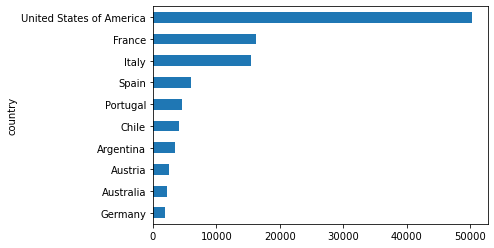

In [144]:
"""Looking at number of reviews by each country to select country with most reviews for word cloud generation """
df1 = df["country"]
num_of_reviews = df1.groupby(df["country"]).count()
num = num_of_reviews.sort_values(ascending=True)

"""Reviews of top 10 countries"""
reviews = num.tail(10)

bargraph = reviews.plot.barh(x='country', y='reviews[1]')

In [145]:
"""Specifiying stopwords for the reviews"""

stopwords_reviews = ["wine", "review", "drink", "bottle", "flavor", "well", 
                     "hint", "finish", "palate", "show", "now", "full",
                     "flavors", "shows", "fruit", "will", "give", "made"]
stopwords_updated = set(STOPWORDS)
stopwords_updated.update(stopwords_reviews)

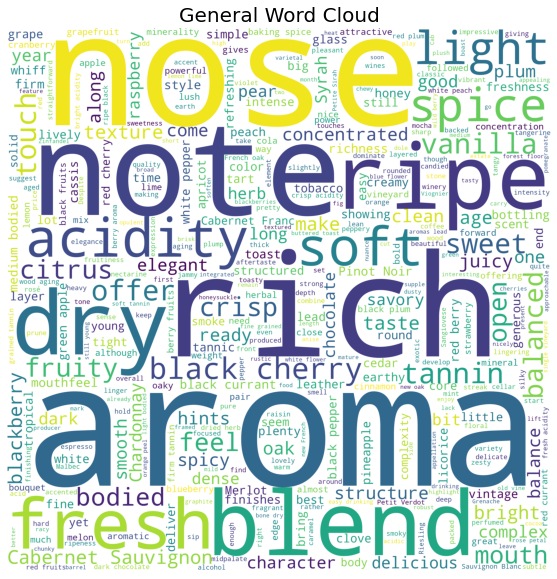

In [146]:
"""Making a general word cloud for all descriptions"""

%matplotlib inline

text = df['description'].astype(str)
wordcloud = WordCloud(stopwords=stopwords_updated,
                      background_color='white',
                      width=3000,height=3000, 
                      max_words=400).generate(" ".join(text)) 

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.title("General Word Cloud",fontsize=20)
plt.axis('off')
plt.show()

In [147]:
"""Using a default dictionary to add all descriptions for every specific country together"""

descriptions = defaultdict(list)
df.apply(lambda words: descriptions[words.country].append(words.description), axis=1)

country_list = list(df.country.unique())
for country in country_list:
    string = ' '.join(descriptions[country])
    descriptions[country] = ' '.join([word.lower() for word in re.sub(re.compile('[^A-Za-z ]+'), ' ', string).split()])

In [148]:
"Making a dictionary with country name as key and file path to base image as value"
base = {}

base['United States of America'] = "usa_bw_map.jpg"
base['France'] = "france_bw_map.jpg"
base['Italy'] = "italy_bw_map.jpg"
base['Spain'] = "spain_bw_map.jpg"
base['Portugal'] = "portugal_bw_map.jpg"
base['Chile'] = "chile_bw_map.jpg"
base['Argentina'] = "argentina_bw_map.jpg"
base['Austria'] = "austria_bw_map.jpg"
base['Australia'] = "australia_bw_map.jpg"
base['Germany'] = "germany_bw_map.jpg"

In [149]:
def country_wordcloud(reviews_country, base_image):
    base = np.array(Image.open(base_image))
    wordcloud = WordCloud(background_color="white", max_words=400, mask=base, 
                   stopwords=stopwords_updated, colormap='jet').generate(reviews_country)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

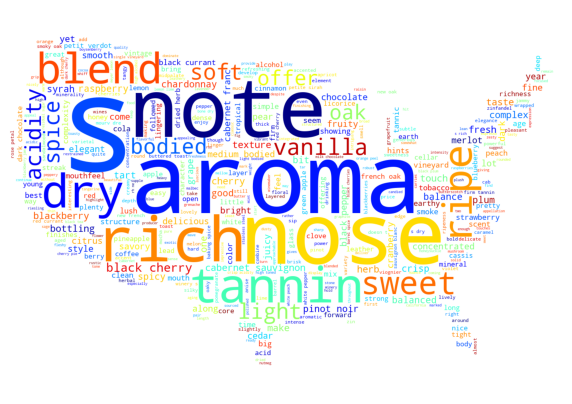

In [150]:
reviews_country = descriptions['United States of America']
wordcloud = country_wordcloud(reviews_country, base['United States of America'])

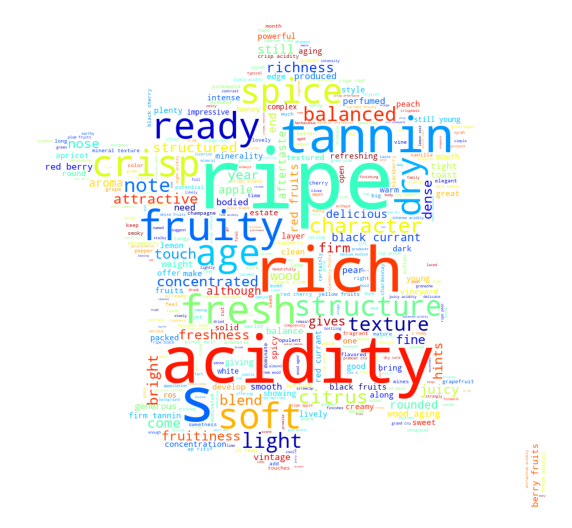

In [151]:
reviews_country = descriptions['France']
wordcloud = country_wordcloud(reviews_country, base['France'])


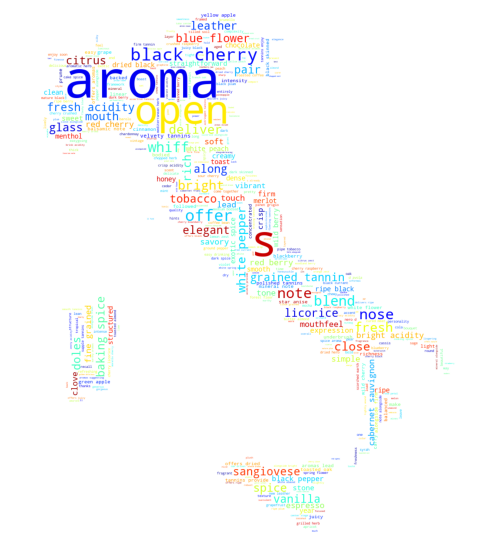

In [152]:
reviews_country = descriptions['Italy']
wordcloud = country_wordcloud(reviews_country, base['Italy'])

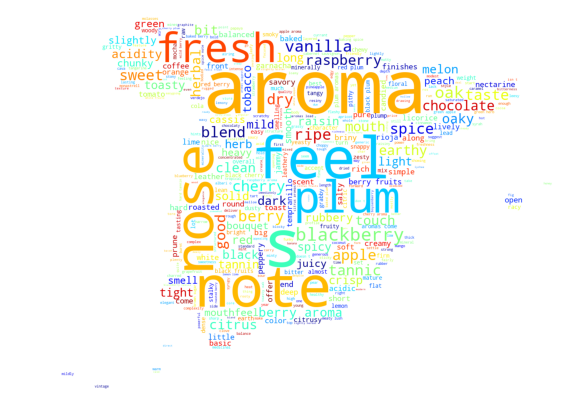

In [153]:
reviews_country = descriptions['Spain']
wordcloud = country_wordcloud(reviews_country, base['Spain'])

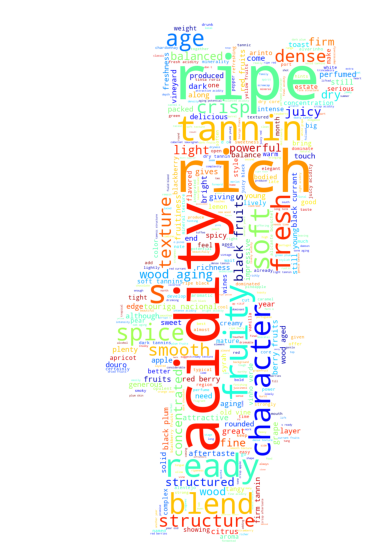

In [154]:
reviews_country = descriptions['Portugal']
wordcloud = country_wordcloud(reviews_country,base ['Portugal'])


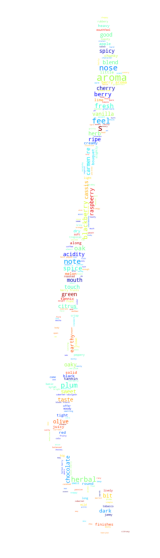

In [155]:
reviews_country = descriptions['Chile']
wordcloud = country_wordcloud(reviews_country, base['Chile'])

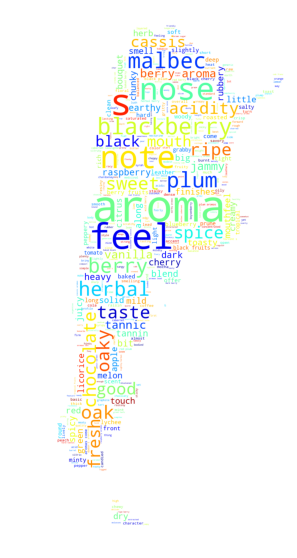

In [156]:
reviews_country = descriptions['Argentina']
wordcloud = country_wordcloud(reviews_country, base['Argentina'])


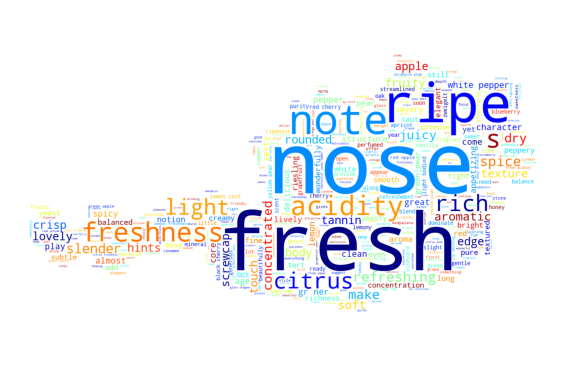

In [157]:
reviews_country = descriptions['Austria']
wordcloud = country_wordcloud(reviews_country, base['Austria'])

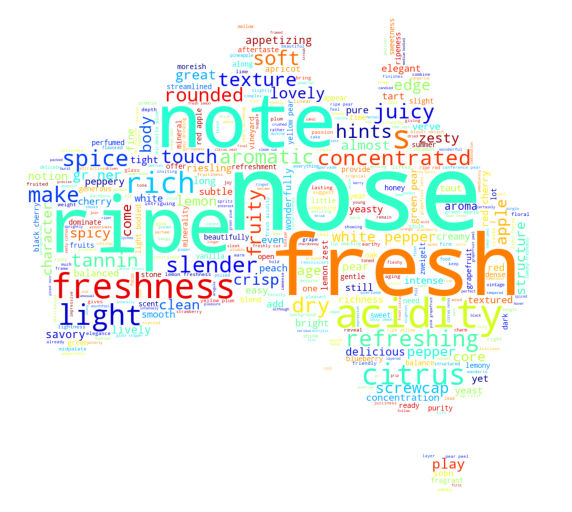

In [158]:
words = descriptions['Australia']
wordcloud = country_wordcloud(reviews_country, base['Australia'])

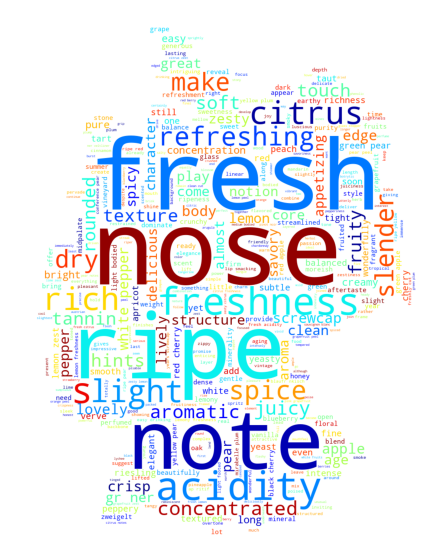

In [159]:
words = descriptions['Germany']
wordcloud = country_wordcloud(reviews_country, base['Germany'])

# Topic modelling

In [160]:
texts = [[word for word in desc.lower().split() if word not in STOPWORDS and word.isalnum() and not word.lower() in ['wine', 'drink']] for desc in list(df["description"].values)]
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence


In [161]:

num_topics = 5 #The number of topics that should be generated
passes = 10
lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes)


In [162]:

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=10))

[   (   0,
        '0.025*"black" + 0.020*"flavors" + 0.019*"cabernet" + 0.019*"fruit" + '
        '0.016*"cherry" + 0.016*"aromas" + 0.014*"notes" + 0.013*"blend" + '
        '0.012*"red" + 0.011*"dark"'),
    (   1,
        '0.048*"aromas" + 0.032*"palate" + 0.023*"flavors" + 0.019*"berry" + '
        '0.017*"black" + 0.015*"finish" + 0.013*"offers" + 0.012*"plum" + '
        '0.011*"red" + 0.011*"opens"'),
    (   2,
        '0.023*"ripe" + 0.020*"acidity" + 0.019*"tannins" + 0.019*"fruit" + '
        '0.015*"rich" + 0.014*"will" + 0.013*"fruits" + 0.013*"red" + '
        '0.012*"well" + 0.012*"black"'),
    (   3,
        '0.022*"flavors" + 0.019*"apple" + 0.018*"white" + 0.018*"citrus" + '
        '0.017*"acidity" + 0.016*"palate" + 0.015*"lemon" + 0.014*"fresh" + '
        '0.014*"crisp" + 0.013*"fruit"'),
    (   4,
        '0.024*"flavors" + 0.014*"oak" + 0.013*"pinot" + 0.011*"sweet" + '
        '0.011*"cherry" + 0.011*"good" + 0.009*"shows" + 0.008*"rich" + '
        '0.008*"

# One-hot coding
One hot encoding is a process used to convert categorical variables into a numerical form that can be used in machine learning algorithms.In below cells, we are making categorical data like country, vareity and province numerical 

In [163]:
# Use get_dummies to create  new binary (0 or 1) feature for each unique category in the categorical variable.
country_array = pd.get_dummies(df[df.columns[0]].values)
province_array =pd.get_dummies(df[df.columns[4]].values)
vareity_array = pd.get_dummies(df[df.columns[5]].values)

In [164]:
# Making a new dataframe using all the predictors price, sentimental analysis score, and categorical data like country
train_df = [df['price'],df['compound'],df['neg'],df['neu'],df['pos'],country_array,province_array,vareity_array,df['points']]
df_model = pd.concat(train_df, axis=1)

In [165]:
df_model.dropna(inplace = True)

In [166]:
df_model

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka,points
0,15.0,0.6486,0.000,0.872,0.128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
1,14.0,-0.1280,0.053,0.947,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
2,13.0,0.3400,0.000,0.930,0.070,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
3,65.0,0.8176,0.000,0.817,0.183,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
4,15.0,0.1655,0.000,0.961,0.039,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111478,18.0,0.4215,0.000,0.920,0.080,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
111479,23.0,0.9716,0.000,0.612,0.388,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
111480,39.0,0.6705,0.000,0.825,0.175,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
111481,29.0,0.4404,0.000,0.927,0.073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0


# Correlation


In [170]:
from scipy.stats import pearsonr
print("Pearson Correlation:", pearsonr(df.price, df.points))

Pearson Correlation: (0.4165936652877664, 0.0)


In [171]:
import statsmodels.api as sm
print(sm.OLS(df.points, df.price).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.431
Method:                 Least Squares   F-statistic:                          8.450e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):                        0.00
Time:                        16:03:22   Log-Likelihood:                     -6.2664e+05
No. Observations:              111511   AIC:                                  1.253e+06
Df Residuals:                  111510   BIC:                                  1.253e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

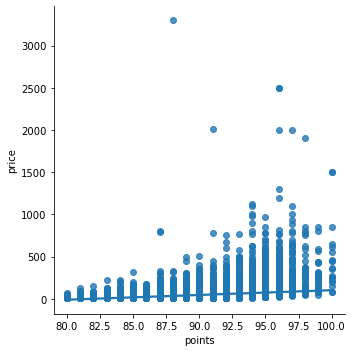

In [172]:
import seaborn as sns
sns.lmplot(y = 'price', x='points', data=df)

# Split 

In [173]:
# Here we split the data two trian data and test data for later model training 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']
x_train

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
55996,49.0,0.0258,0.000,0.970,0.030,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40551,35.0,0.1027,0.000,0.945,0.055,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36596,45.0,0.2023,0.000,0.938,0.062,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45822,42.0,0.6597,0.000,0.870,0.130,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76711,16.0,0.4404,0.000,0.903,0.097,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109965,75.0,0.6597,0.000,0.899,0.101,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68180,12.0,0.6115,0.045,0.833,0.121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32900,36.0,0.7579,0.035,0.810,0.155,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49593,30.0,0.9694,0.000,0.589,0.411,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear Regression
We can see that linear regression did really bad on predicting points

In [174]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.LinearRegression()
model.fit(x_train,y_train)
model.coef_

array([ 2.56731184e-02,  5.03878369e+00,  7.94740856e+01, ...,
        1.38885020e-01, -2.52392884e+00, -1.19606972e+00])

In [61]:
from sklearn.metrics import r2_score
import math
training_predictions = model.predict(x_train)
testing_predictions  = model.predict(x_test)
#r2_score(y_test, testing_predictions)
mse = mean_squared_error(y_test, testing_predictions)
rmse = math.sqrt(mse)
mse
#metrics.accuracy_score(y_test, y_pred)

25097462584423.22

In [62]:
print("Training R-Square",model.score(x_train,y_train))
print("Testing R-Square",model.score(x_test,y_test))

Training R-Square 0.3983929879986058
Testing R-Square -2911051368674.513


In [63]:

r2_score(y_test, testing_predictions)


-2911051368674.513

# Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logit = LogisticRegression()
logit.fit(x_train,y_train)
y_pred = logit.predict(x_test)


In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

2.4740845264762625

In [66]:
r2_score(y_test, y_pred)

0.29001508749008653

In [68]:
#from sklearn import metrics
#metrics.accuracy_score(y_test, y_pred)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


for i in range(10,30):
    dt_model = tree.DecisionTreeRegressor(max_depth=i)
#model = DecisionTreeRegressor(max_depth = 3)
    print(i,dt_model.fit(x_train,np.ravel(y_train)),dt_model.score(X=x_test, y=y_test))
y_pred =dt_model.predict(x_test)

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
dt_model = tree.DecisionTreeRegressor(max_depth=17)
dt_model.fit(x_train,np.ravel(y_train))
dt_model.score(X=x_test, y=y_test)
y_pred =dt_model.predict(x_test)
#metrics.accuracy_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4133633467873823
0.3244375862191127


In [ ]:
accuracy_score(y_test, y_pred)

# RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=20,min_samples_leaf=10,min_samples_split=10,n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.522391814936409
0.2639876218417384


In [77]:
y_pred =rf_model.predict(x_test).round()
accuracy_score(y_test, y_pred)

0.16192970365265336

# BaggingClassifier

In [72]:
from sklearn.ensemble import BaggingClassifier
b_model=BaggingClassifier()
b_model.fit(x_train,np.ravel(y_train))
y_pred =b_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.629450535792051
0.19804487980909335


In [79]:
accuracy_score(y_test, y_pred)

0.19354927636113026

# KNN

In [73]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train,y_train)
knn.score(x_test, y_test)

y_pred =knn.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4691413642264064
0.29284931935282754


In [38]:
mse = mean_squared_error(y_test, knn.predict(x_test))
rmse = math.sqrt(mse)
rmse

2.4199868428938744

In [103]:
accuracy_score(y_test, knn.predict(x_test).round())

0.17739490006891798

# Making Points Categorical

Due to all of above models having very low accuracy, in order to better predict quality the quality column was changed to a categorical data type with values A, B, C, and D. According to the EDA we have done previously, points of wine are normally distributed. Therefore we can set the range of each quality points A, B, C, and D are from 100 to 95, 95 to 90, 90 to 85, and 85 to 80 respectively. It is also not that important to predict the exact wine point since a point with 93 is not that different than a wine with point 93.5

In [175]:
# Assign levels base on points of the wine to make points categorical data
for i in df_model['points']:
    if i > 95:
        df_model['level'] = 'A'
    elif i < 95 and i>= 90:
        df_model['level'] = 'B'
    elif i < 90 and i >= 85:
        df_model['level'] = 'C'
    elif i < 85 and i>= 80:
        df_model['level'] = 'D'


In [176]:
df_classif = df_model

# Split data

In [177]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_classif, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']

89126    84.0
38380    86.0
40612    88.0
8173     89.0
960      88.0
         ... 
24175    87.0
14381    93.0
76450    87.0
95015    84.0
4636     88.0
Name: points, Length: 72406, dtype: float64

# RandomForestClassifier

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_model = RandomForestClassifier(n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))
accuracy_score(y_test, y_pred)

0.6039207636223562
0.9614207302408796


0.8994908481567414

              precision    recall  f1-score   support

        80.0       0.36      0.11      0.17        91
        81.0       0.54      0.14      0.22       193
        82.0       0.54      0.35      0.42       464
        83.0       0.65      0.43      0.52       783
        84.0       0.74      0.82      0.77      1568
        85.0       0.84      0.96      0.90      2335
        86.0       0.96      0.99      0.97      3066
        87.0       0.99      1.00      0.99      4009
        88.0       1.00      1.00      1.00      4104
        89.0       0.98      0.99      0.98      2835
        90.0       0.93      0.99      0.96      3536
        91.0       0.92      0.94      0.93      2725
        92.0       0.84      0.90      0.87      2230
        93.0       0.75      0.79      0.77      1545
        94.0       0.66      0.58      0.62       940
        95.0       0.62      0.23      0.33       401
        96.0       0.42      0.08      0.13       126
        97.0       0.29    

<AxesSubplot:>

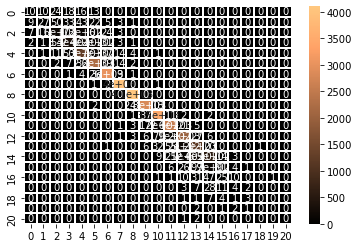

In [184]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),cmap='copper',annot=True,linewidths=1,linecolor='white')

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model2 = SVC(kernel='linear', C=10) # kernel and C are the main args to adjust for linear SVC
model2.fit(x_train, y_train)
model2.score(x_train, y_train)

# Recommendation system

In [ ]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [ ]:
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)


In [ ]:

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)



In [ ]:

for n in range(3):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')